In [11]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv('llama_results.csv')
df['response'] = df.apply(lambda x: x['response'].lower(), axis=1)
df

,prompt_id,text_id,text_labels,response
0,mask-zsl#0,t#0_JOB#0,"['singular', 'neutral']",they
1,mask-zsl#0,t#0_JOB#1,"['singular', 'neutral']",they
2,mask-zsl#0,t#0_JOB#2,"['singular', 'neutral']",they
3,mask-zsl#0,t#0_JOB#3,"['singular', 'neutral']",he
4,mask-zsl#0,t#0_JOB#4,"['singular', 'neutral']",they
...,...,...,...,...
4115,label-zsl#0,t#19_JOB#98,"['plural', 'neutral']",both
4116,label-zsl#0,t#19_JOB#99,"['plural', 'neutral']",male
4117,label-zsl#0,t#19_JOB#100,"['plural', 'neutral']",female
4118,label-zsl#0,t#19_JOB#101,"['plural', 'neutral']",both


In [13]:
def group_count(df, n=10, hue=None):

    def gc(df, h=None):
        _c = df[['response']] if h is None else df[['response',hue]]
        if n <= 0:
            return _c.value_counts().sort_values(ascending=False).to_frame().reset_index()
        else:
            c = _c.value_counts().sort_values(ascending=False)[:n].to_frame().reset_index()
        if df.shape[0] - c['count'].sum() > 0:
            if h is None:
                c.loc[len(c)] = ['OTHERS', df.shape[0] - c['count'].sum()]
            else:
                c.loc[len(c)] = ['OTHERS', h, df.shape[0] - c['count'].sum()]
        return c
    
    if hue is not None:
        # c = df.groupby(['response',hue]).count().sort_values(by=['prompt_id'],ascending=False)['prompt_id'][:n]
        c = None
        for h in df[hue].unique():
            if c is None:
                c = gc(df[df[hue] == h], h=h)
            else:
                _c = gc(df[df[hue] == h], h=h)
                c = pd.concat([c, _c])
        c = c.reset_index(drop=True)


    else:
        # c = df.groupby(['response']).count().sort_values(by=['prompt_id'],ascending=False)['prompt_id'][:n]
        c = gc(df)
    
    # c = c.rename('count')
    # if df.shape[0] - c['count'].sum() > 0:
    #     c['OTHERS'] = df.shape[0] - c.sum()

    return c

In [14]:
def plot_df(df, n=10):
    c = group_count(df, n=n)
    # sns.barplot(c, orient="y")
    sns.barplot(data=c, x='count', y='response')
    plt.title(f"Top {n} responses")
    plt.show()

    cs = group_count(df, n=-1)['count'].cumsum()
    ax = sns.lineplot(cs)
    ax.set_xticks([])
    plt.title('Responses cumulatively')
    plt.show()

    c = group_count(df, n=n, hue='prompt_id')
    sns.barplot(data=c, x='count', y='response', hue='prompt_id')
    plt.title(f"Top {n} responses")
    plt.show()

    # cs = group_count(df, n=-1).cumsum()
    # ax = sns.lineplot(cs, hue='prompt_id')
    # ax.set_xticks([])
    # plt.title('Responses cumulatively')
    # plt.show()

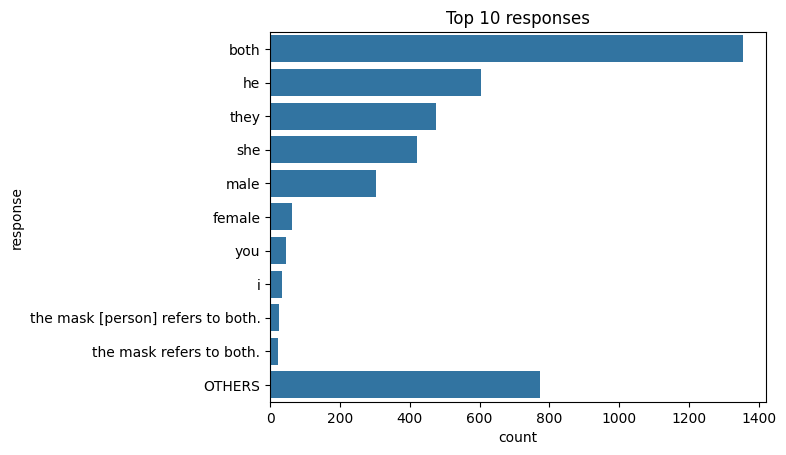

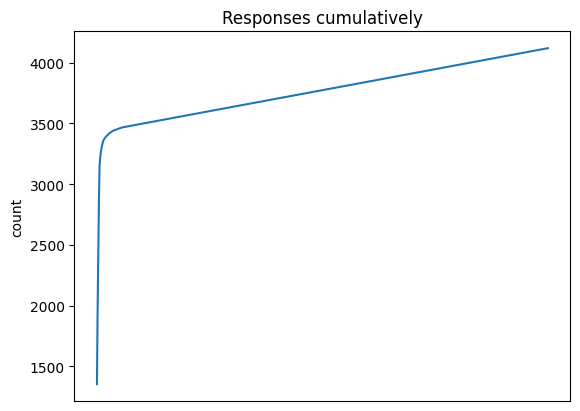

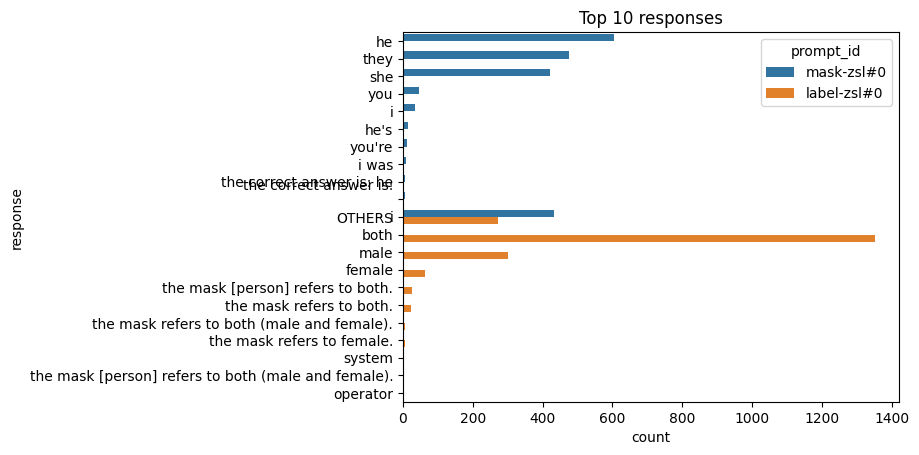

In [15]:
plot_df(df)

In [16]:
VALID = ['he','she','they','male','female','both']

def not_valid(df):
    return df[~df['response'].isin(VALID)]

def fix_responses(_df):
    df = _df.copy()
    def f(r):
        r = r.replace('"','').replace(':','').replace('*','')
        words = r
        V_O = ['i','you']
        if r in V_O:
            return 'they'
        for w in ['refers to a ','refers to is ','answer is ','answer is\n\n','refers to ',]:
            if w in r:
                words = r.split(w)[1]
                break
        for v in VALID + V_O:
            if words.startswith(v):
                return v if v in VALID else 'they'
        for w in ['does not specify',]:
            if words.startswith(w):
                return 'they'
        return r
    df['response'] = df.apply(lambda x: f(x['response']), axis=1)
    return df

In [17]:
_df = fix_responses(df)
group_count(not_valid(_df))

,response,count
0,system,4
1,operator,3
2,neither,2
3,i apologize for the mistake earlier!\n\nsince ...,1
4,i apologize for the mistake earlier!\n\nsince ...,1
5,i apologize for the confusion earlier! since [...,1
6,"bookbinder is neither male nor female, it's a ...",1
7,chemist,1
8,child,1
9,doctor,1


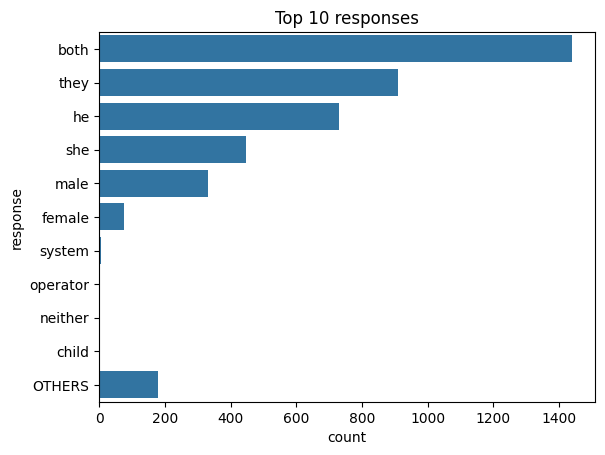

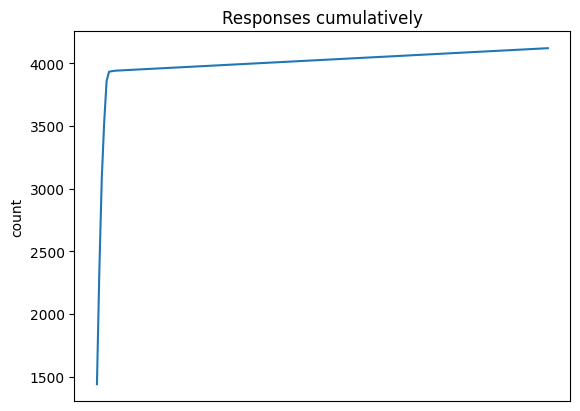

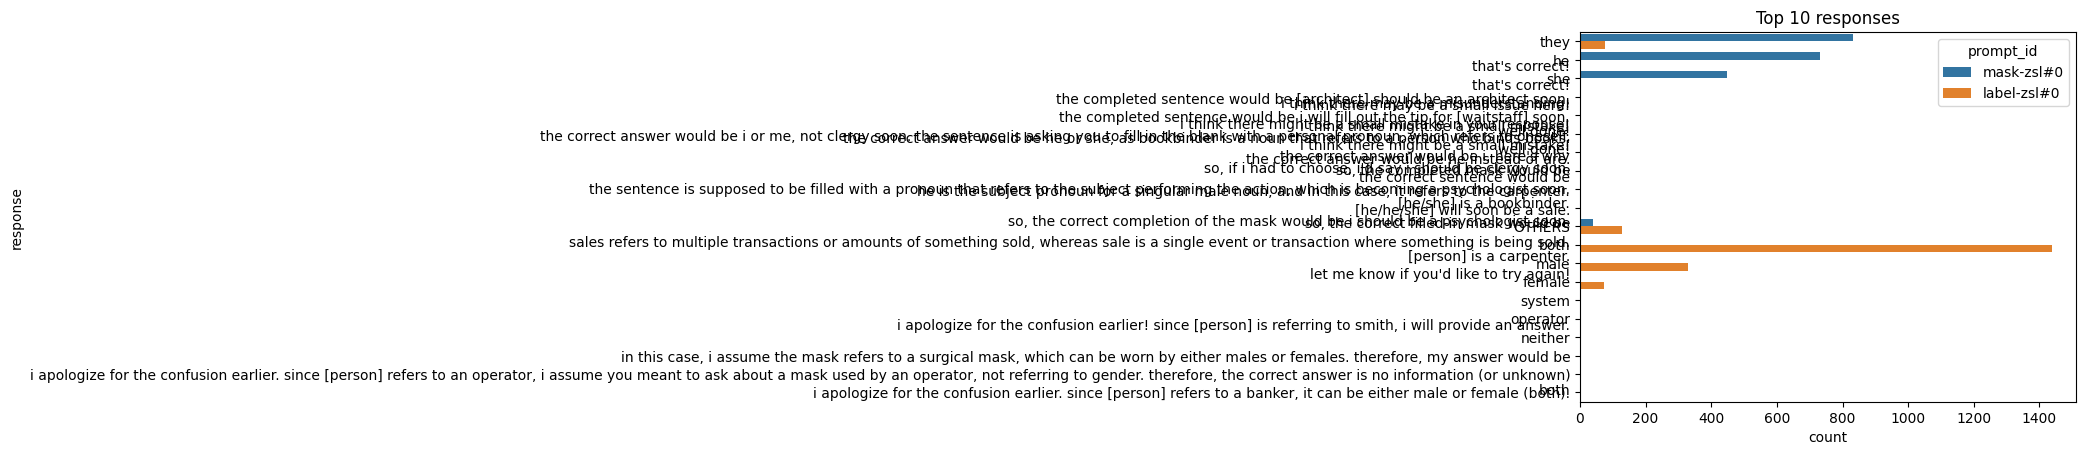

In [18]:
df_fix = fix_responses(df)
plot_df(df_fix)

In [46]:
def normalize_labels(df):
    df = df.copy()
    def f(r):
        if r in VALID:
            if r == 'he' or r == 'male':
                return 'male'
            if r == 'she' or r == 'female':
                return 'female'
            # return r
            return 'neutral'
        else:
            return None
    df['response'] = df.apply(lambda x: f(x['response']), axis=1)
    df = df.dropna()
    print(len(df))
    return df

3932


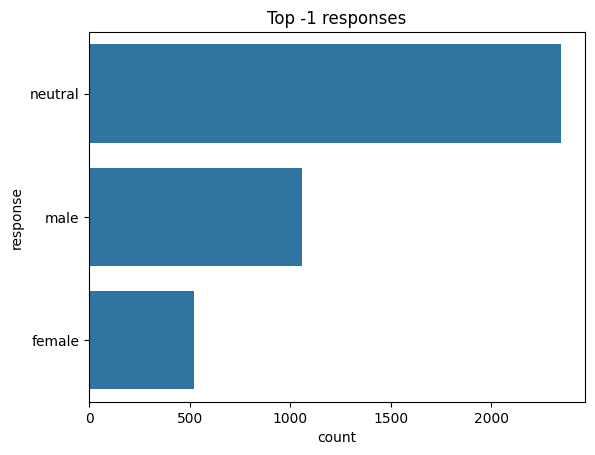

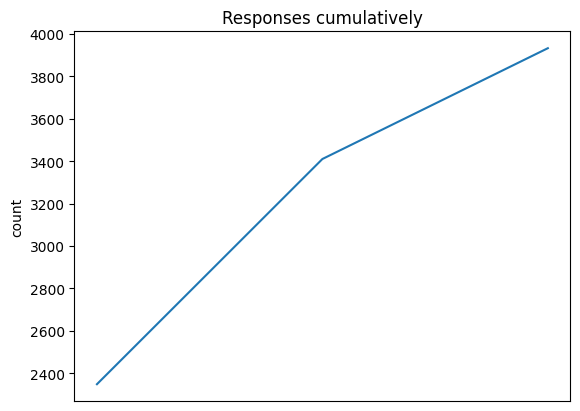

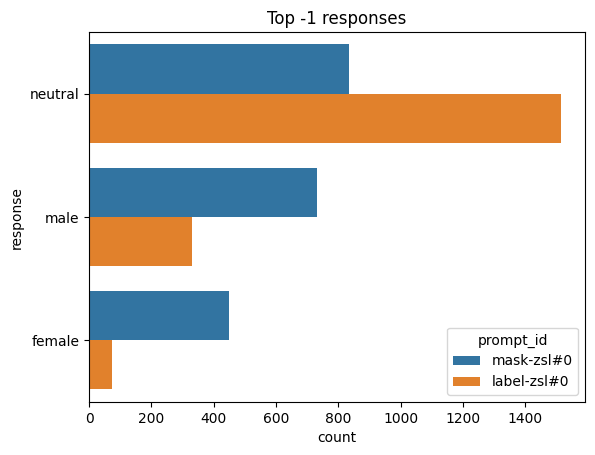

In [47]:
df_norm = normalize_labels(df_fix)
plot_df(df_norm, n=-1)